RNN 실습



1. 데이터셋 전처리
2. RNN 모델 구성
3. 다음 글자 예측 및 생성



In [1]:
#경로설정 #구글드라이브의 data 폴더로
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/data')

Mounted at /content/gdrive


# 1. 데이터셋 전처리

무료 제공 전자책 The Mysterious Island를 사용하여 진행

In [2]:
import numpy as np

## 텍스트 읽고 전처리하기
with open('1268-0.txt', 'r', encoding="utf8") as fp: #경로설정하고 실행할것
    text=fp.read()

    start_indx = text.find('THE MYSTERIOUS ISLAND')
    end_indx = text.find('End of the Project Gutenberg')

    text = text[start_indx:end_indx]
    char_set = set(text)
    print('전체 길이:', len(text))
    print('고유한 문자:', len(char_set))

전체 길이: 1112350
고유한 문자: 80


In [5]:
print(text)

THE MYSTERIOUS ISLAND ***




Produced by Anthony Matonak, and Trevor Carlson





THE MYSTERIOUS ISLAND

by Jules Verne

1874




PART 1--DROPPED FROM THE CLOUDS



Chapter 1

“Are we rising again?” “No. On the contrary.” “Are we descending?”
 “Worse than that, captain! we are falling!” “For Heaven’s sake heave out
the ballast!” “There! the last sack is empty!” “Does the balloon rise?”
 “No!” “I hear a noise like the dashing of waves. The sea is below the
car! It cannot be more than 500 feet from us!” “Overboard with every
weight! ... everything!”

Such were the loud and startling words which resounded through the air,
above the vast watery desert of the Pacific, about four o’clock in the
evening of the 23rd of March, 1865.

Few can possibly have forgotten the terrible storm from the northeast,
in the middle of the equinox of that year. The tempest raged without
intermission from the 18th to the 26th of March. Its ravages were
terrible in America, Europe, and Asia, covering a distance

In [4]:
print(char_set) #고유문자 집합set

{'8', 'q', 'c', 'I', 'V', '7', ':', 'y', 'Z', '\n', '*', '5', 'B', 'T', 's', 'b', 'P', 'k', 'M', '0', 'G', '-', 'O', '!', '.', 'C', 'l', 'o', 'g', 'z', 'H', 'W', 'J', 'E', 'f', ' ', 'N', 'r', 'x', '3', 'L', ')', 'w', '=', ';', 'D', '“', 'S', 'e', 'v', '?', 'n', 'm', 'd', 'u', '(', 't', 'A', '1', 'a', 'Q', 'p', '4', '&', '‘', 'h', '2', '6', 'K', ',', 'Y', 'U', 'F', '/', '’', 'j', 'R', '9', 'i', '”'}


신경망 라이브러리는 문자열을 지원하지 않음 --> 숫자 형태로 바꾸기

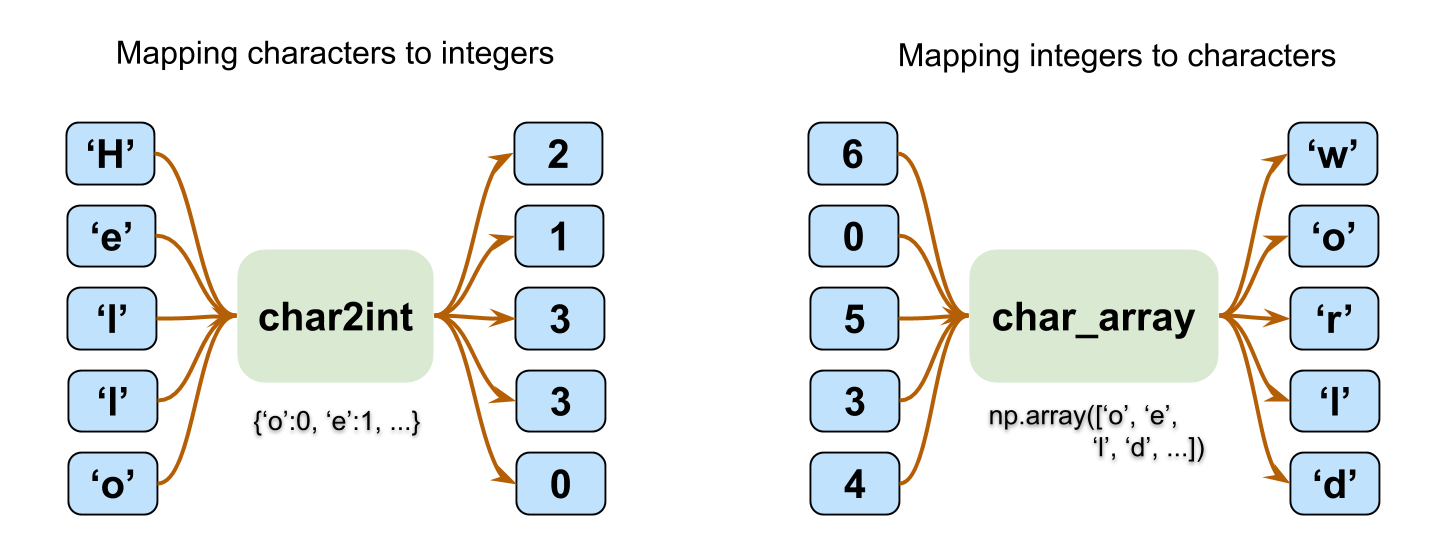

In [3]:
chars_sorted = sorted(char_set) #고유문자 집합 정렬
char2int = {ch:i for i,ch in enumerate(chars_sorted)} #문자(ch)를 키(key)로, 그에 대응되는 인덱스(i)를 값(value)으로 가지는 딕셔너리를 만듭니다.
char_array = np.array(chars_sorted)

text_encoded = np.array(
    [char2int[ch] for ch in text],
        dtype=np.int32) #텍스트의 각 문자 ch를 해당하는 정수 char2int[ch]로 변환합니다. 결과는 정수들의 리스트가 됩니다.

print('인코딩된 텍스트 크기: ', text_encoded.shape)

print(text[:15], '     == 인코딩 ==> ', text_encoded[:15])
print(text_encoded[15:21], ' == 디코딩  ==> ', ''.join(char_array[text_encoded[15:21]]))

인코딩된 텍스트 크기:  (1112350,)
THE MYSTERIOUS       == 인코딩 ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == 디코딩  ==>  ISLAND


In [11]:
for ex in text_encoded[:5]:
      print('{} -> {}'.format(ex, char_array[ex]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


모델의 목표 : 다음 문자 예측하기 (X,y) = (이전문장, 다음 글자)



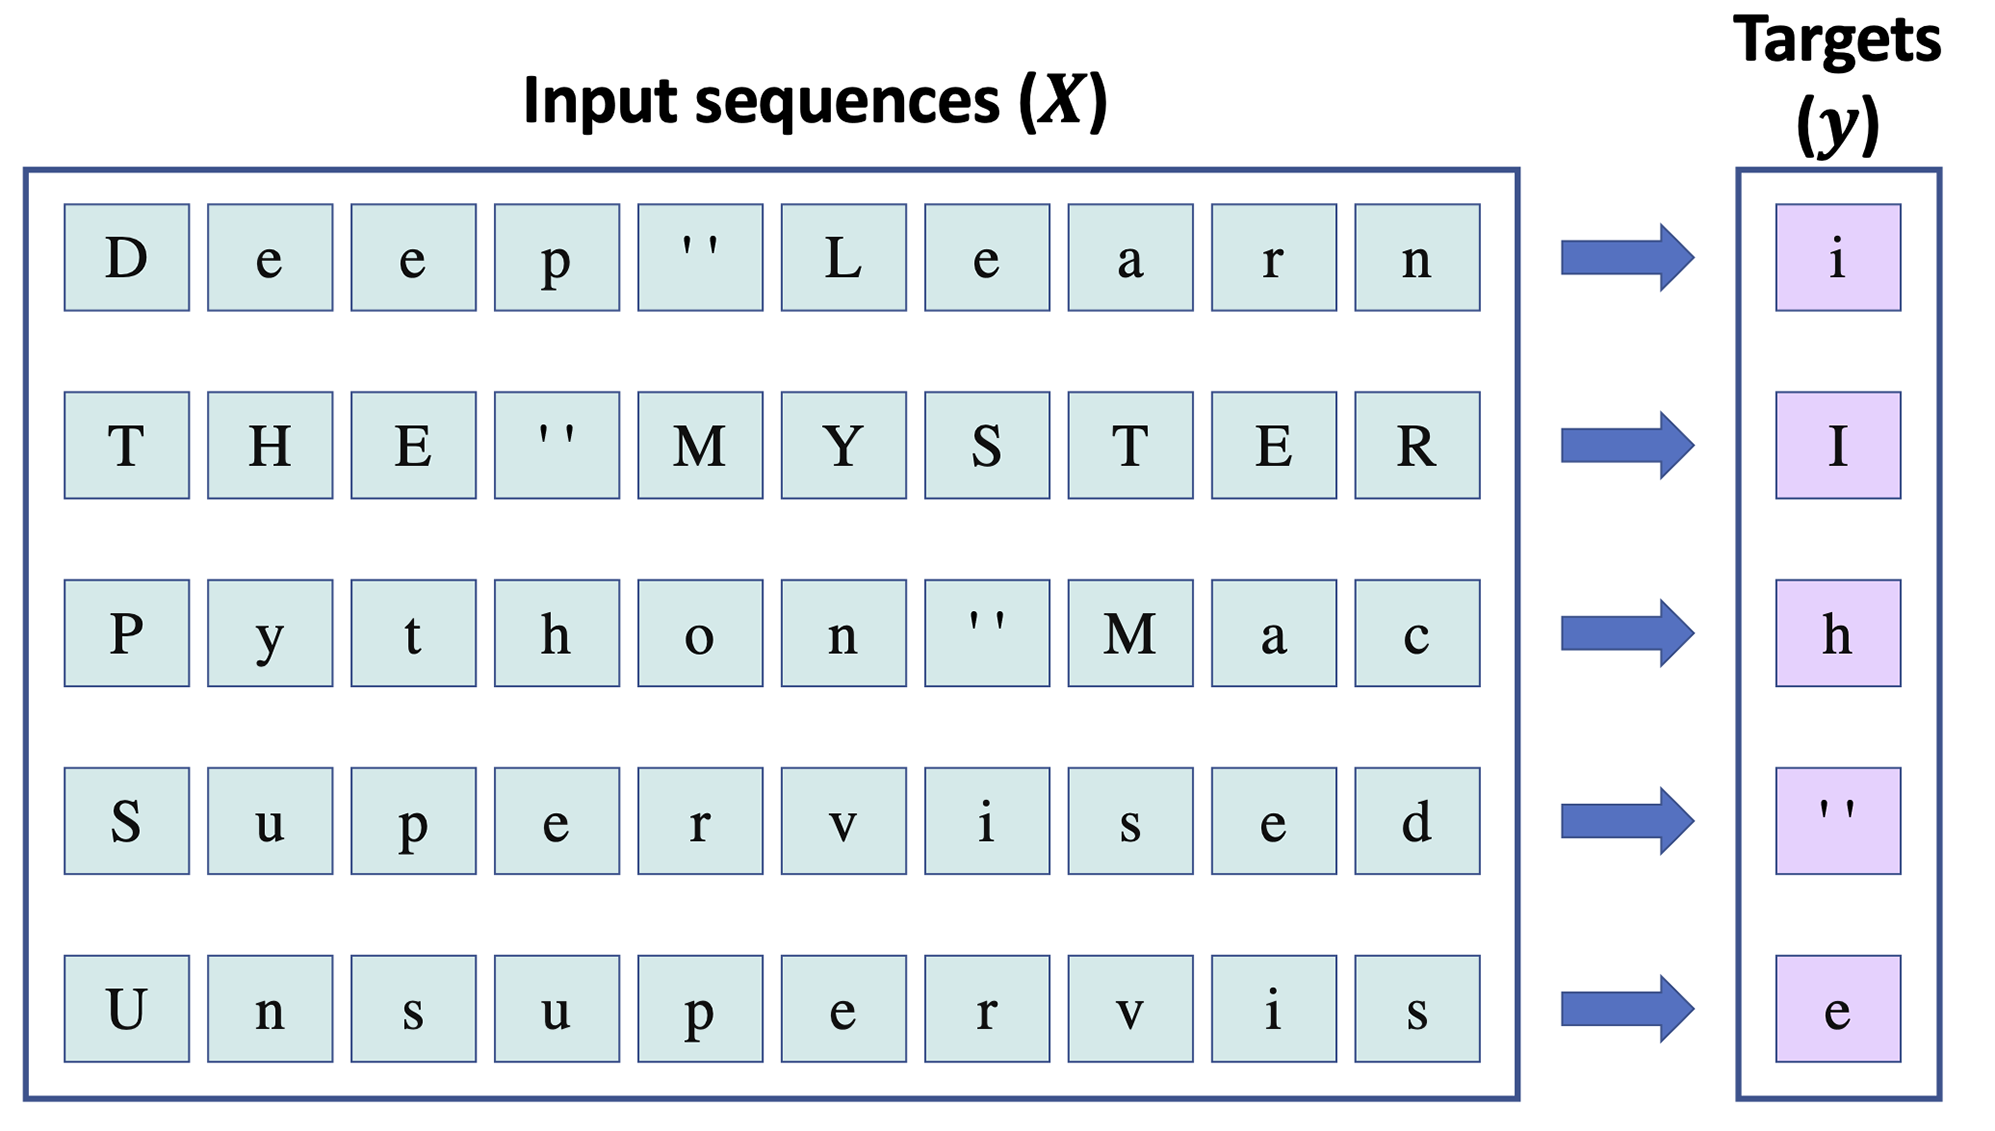

시퀀스 길이 40인 RNN 모델을 사용. why? 너무 짧으면 "문맥"을 무시하고 개별 단어를 감지하게끔 학습됨. 길수록 더 의미있는 문장을 만들 수 있음. 적절한 시퀀스 길이는 하이퍼 파라미터 최적화 문제

In [4]:
#X, y 만들기
seq_length = 40
chunk_size = seq_length + 1 #문장 40글자와 다음 글자(y) 1글자

text_chunks = [text_encoded[i:i+chunk_size]
               for i in range(len(text_encoded)-chunk_size+1)] #i번째 위치부터 i+chunk_size(총41개)까지 잘라내는걸 for문 반복

## 조사:
for seq in text_chunks[:1]:
    input_seq = seq[:seq_length]
    target = seq[seq_length]
    print(input_seq, ' -> ', target)
    print(repr(''.join(char_array[input_seq])),
    ' -> ', repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


In [14]:
text_chunks[0]

array([44, 32, 29,  1, 37, 48, 43, 44, 29, 42, 33, 39, 45, 43,  1, 33, 43,
       36, 25, 38, 28,  1,  6,  6,  6,  0,  0,  0,  0,  0, 40, 67, 64, 53,
       70, 52, 54, 53,  1, 51, 74], dtype=int32)

다중분류 기반의 텍스트 생성

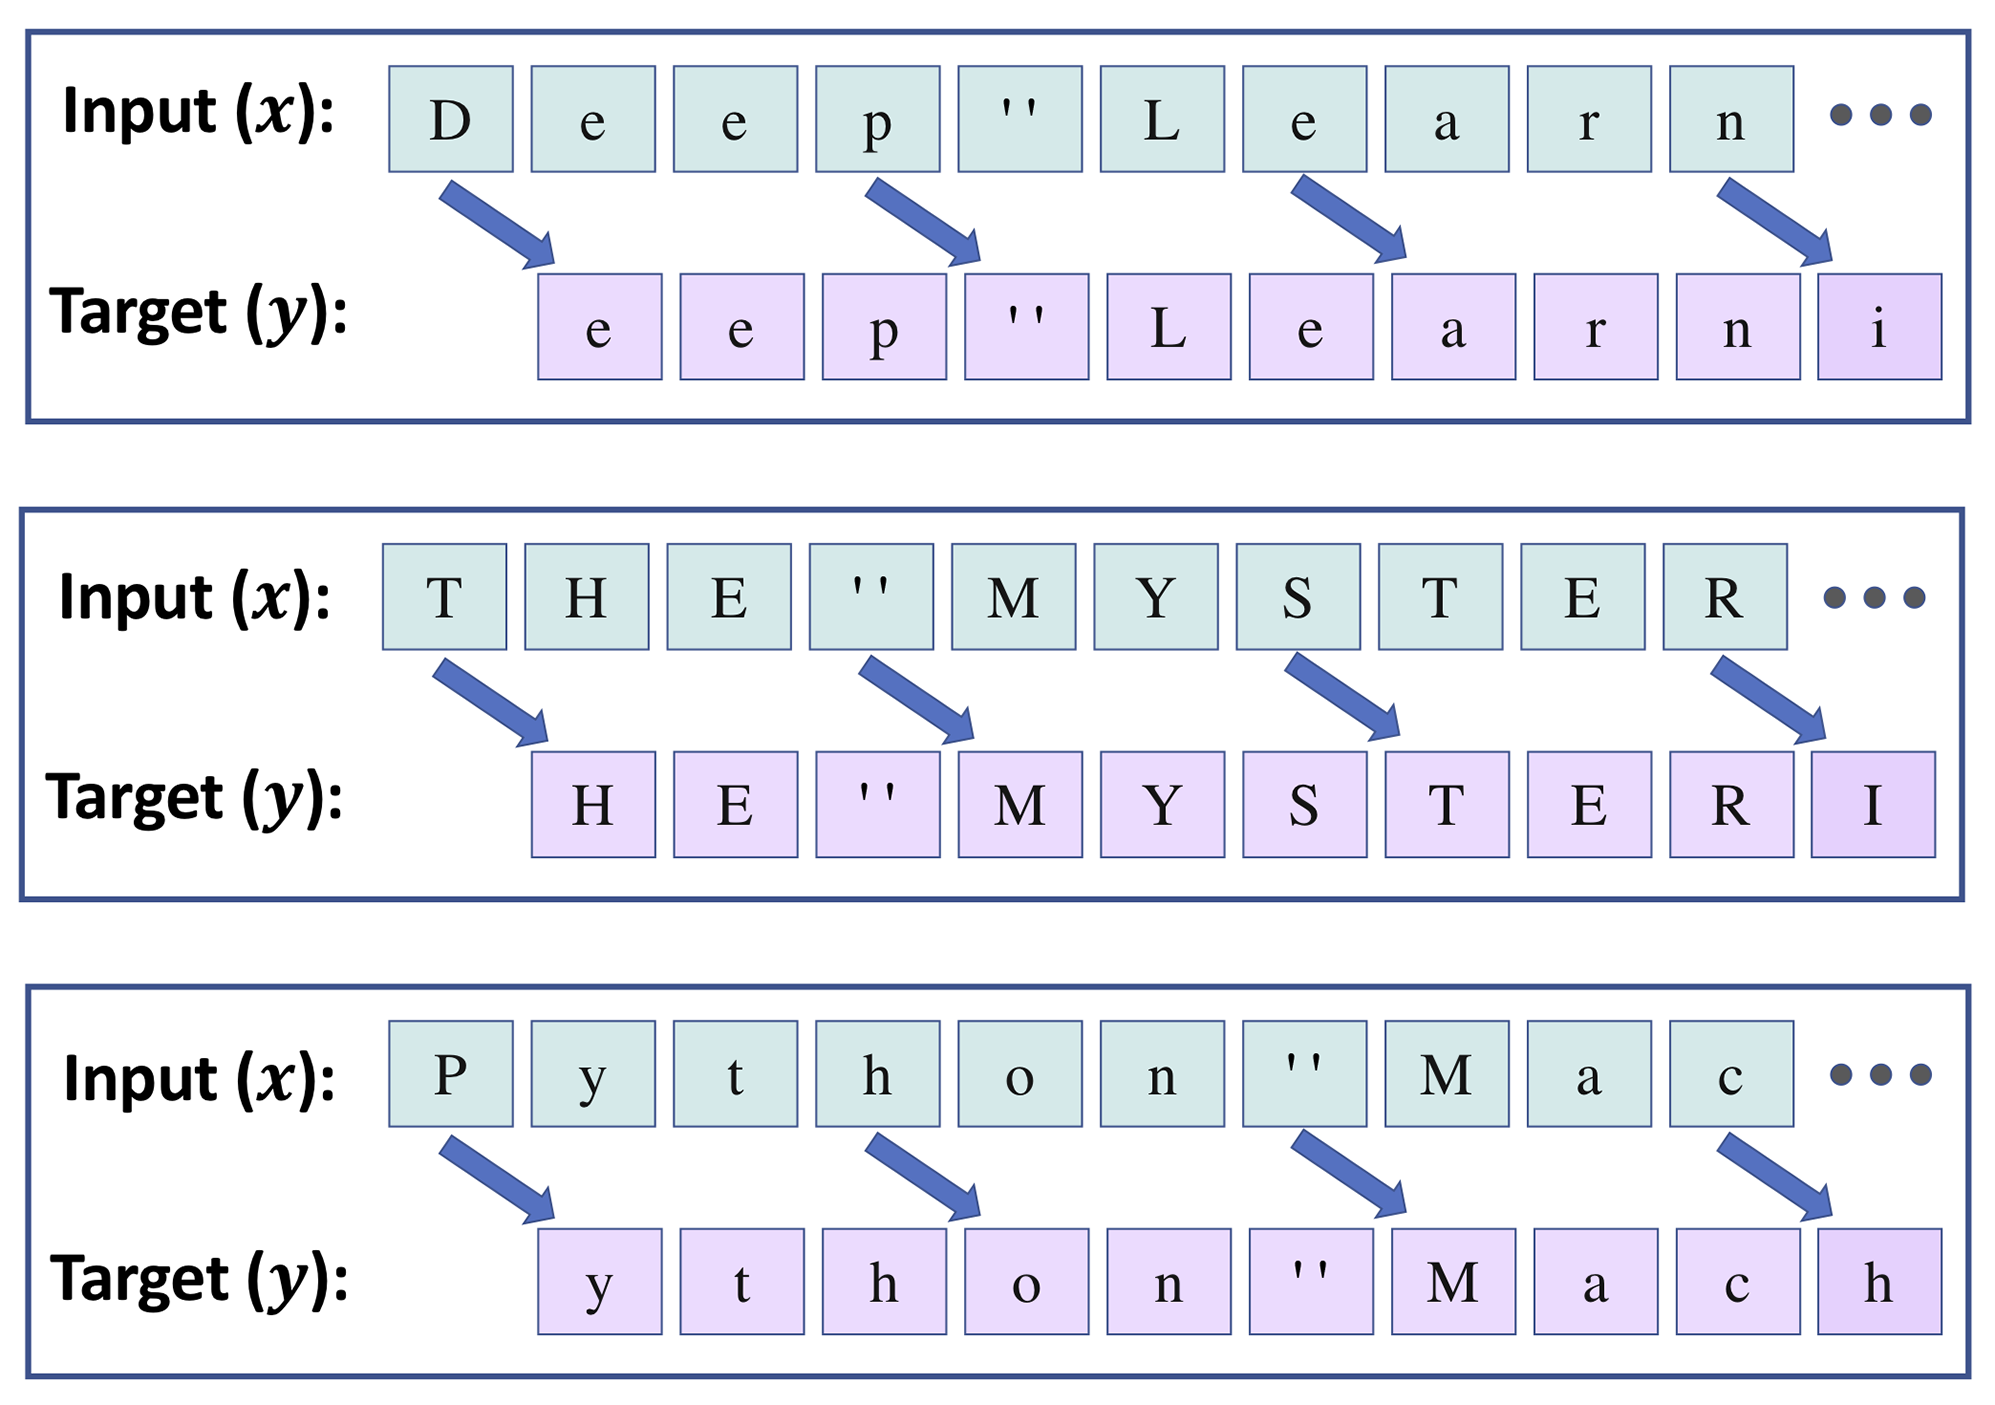

In [5]:
#Dataset으로 결합
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long() #첫 40개가 X, 뒤에서부터 40개가 y

seq_dataset = TextDataset(torch.tensor(text_chunks))

<ipython-input-5-edfbb4da5796>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  seq_dataset = TextDataset(torch.tensor(text_chunks))


In [19]:
for i, (seq, target) in enumerate(seq_dataset):
    print('입력 (x):', repr(''.join(char_array[seq])))
    print('타깃 (y):', repr(''.join(char_array[target])))
    print()
    if i == 1:
        break

입력 (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
타깃 (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

입력 (x): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'
타깃 (y): 'E MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by '



In [6]:
#데이터로더로 미니배치 변환
from torch.utils.data import DataLoader

batch_size = 64

torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 2. RNN 모델 구성

In [10]:
device = torch.device("cuda:0") #GPU 없으면 지우기
# device = 'cpu'

In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(device), cell.to(device)

vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model = model.to(device) #안되면 지우기
model

RNN(
  (embedding): Embedding(80, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=80, bias=True)
)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10000

torch.manual_seed(1)

for epoch in range(num_epochs):
    hidden, cell = model.init_hidden(batch_size)
    seq_batch, target_batch = next(iter(seq_dl))
    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)
    optimizer.zero_grad()
    loss = 0
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()
    optimizer.step()
    loss = loss.item()/seq_length
    if epoch % 500 == 0:
        print(f'에포크 {epoch} 손실: {loss:.4f}')

에포크 0 손실: 4.3722
에포크 500 손실: 1.3898
에포크 1000 손실: 1.3400
에포크 1500 손실: 1.2286
에포크 2000 손실: 1.2124
에포크 2500 손실: 1.2104
에포크 3000 손실: 1.1689
에포크 3500 손실: 1.1464
에포크 4000 손실: 1.1881
에포크 4500 손실: 1.1509
에포크 5000 손실: 1.0978
에포크 5500 손실: 1.1258
에포크 6000 손실: 1.1502
에포크 6500 손실: 1.1107
에포크 7000 손실: 1.1130
에포크 7500 손실: 1.1729
에포크 8000 손실: 1.1390
에포크 8500 손실: 1.1626
에포크 9000 손실: 1.1164
에포크 9500 손실: 1.0988


In [13]:
#모델 저장
MODEL_PATH = '/content/gdrive/My Drive/data'
torch.save(model, os.path.join(MODEL_PATH, "RNN_mysteri.pt"))

In [15]:
#모델 불러오기
model = torch.load(os.path.join(MODEL_PATH, "RNN_mysteri.pt"), weights_only=False)
print(model)

RNN(
  (embedding): Embedding(80, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=80, bias=True)
)


# 3. 다음 글자 예측 및 생성


In [19]:
from torch.distributions.categorical import Categorical

torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 1.0]])

print('확률:', nn.functional.softmax(logits, dim=1).numpy()[0])

m = Categorical(logits=logits)
samples = m.sample((10,))

print(samples.numpy())

확률: [0.33333334 0.33333334 0.33333334]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [2]
 [1]
 [1]]


In [20]:
torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 3.0]])

print('확률:', nn.functional.softmax(logits, dim=1).numpy()[0])

m = Categorical(logits=logits)
samples = m.sample((10,))

print(samples.numpy())

확률: [0.10650698 0.10650698 0.78698605]
[[0]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]]


In [21]:
def sample(model, starting_str,
           len_generated_text=500,
                      scale_factor=1.0):

    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.eval()
    hidden, cell = model.init_hidden(1)
    hidden = hidden.to('cpu')
    cell = cell.to('cpu')
    for c in range(len(starting_str)-1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)

    last_char = encoded_input[:, -1]
    for i in range(len_generated_text):
        logits, hidden, cell = model(last_char.view(1), hidden, cell)
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])

    return generated_str

torch.manual_seed(1)
model.to('cpu')
print(sample(model, starting_str='The island'))

The island was beginning, and even an iron unless to
find Ayrton. Estaway in his eyes pigues, in numbery at the special couple of his caress; the youngly
rise everything, fast thus
smoked
away. It is useedation,” replied Pencroft, double ever returned as severally accurely at the load of the water hollowed its appect for this word, and a promontory, on the depth, and which has been other private
him badred repeat,
wood, and that is to say that at long whalers thrown from an
exactly on the flash. There was
